<h1 align='center'>Actuarial Loss Prediction </h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from tensorflow.keras import models, layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

sns.set()
%matplotlib inline

## Business Understanding

Actuarial science is a discipline that assesses current financial risks of future contingent events (especially insured events) using mathematical and statistical methods. It covers methodologies and techniques for pricing, determining liabilities, etc., to ensure the company can meet its liabilities as they fall due. In some insurance products such as workers compensation (a form of insurance that pays workers who are injured or become disabled as a result of their job) where the payments can last for years, predicting the ultimate incurred claim cost (total claims payments by the insurance company to policyholders) is significant to determine the liabilities and prepare the cash to pay for benefits. It can be done by using traditional actuarial methods such as grouping some policyholders based on similarity and use the expected value of the group for prediction. However, this method requires much physical labor to determine the groupings, trade-offs between the number of groups and accuracy, etc. Machine learning methodologies can be used to group the policyholders using unsupervised learning (e.g., kmeans) or directly predict the ultimate incurred claim cost for every claim (regression). In this notebook, we will try some regression models to predict the ultimate incurred claim cost and compare it to the actuarial methods by using the [dataset](https://www.kaggle.com/c/actuarial-loss-estimation) provided by The Actuaries Institute of Australia, Institute and Faculty of Actuaries, and the Singapore Actuarial Society. Limited data availability may cause actuarial methods to perform better. Nevertheless, machine learning algorithms can speed up this prediction process and incorporate other features such as claim description using NLP.

## Data Understanding

In [2]:
df = pd.read_csv('data/train.csv')
df_copy = df.copy()
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


In [3]:
# Fix incorrect column name
df.rename(columns={'InitialIncurredCalimsCost': 'InitialIncurredClaimCost'}, inplace=True)
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredClaimCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


In [4]:
df.isna().sum()

ClaimNumber                   0
DateTimeOfAccident            0
DateReported                  0
Age                           0
Gender                        0
MaritalStatus                29
DependentChildren             0
DependentsOther               0
WeeklyWages                   0
PartTimeFullTime              0
HoursWorkedPerWeek            0
DaysWorkedPerWeek             0
ClaimDescription              0
InitialIncurredClaimCost      0
UltimateIncurredClaimCost     0
dtype: int64

Only the `MaritalStatus` column that has missing values. Because there are separate categories for unknown marital status, we will change this missing values to U (Unknown).

In [5]:
df.dtypes

ClaimNumber                   object
DateTimeOfAccident            object
DateReported                  object
Age                            int64
Gender                        object
MaritalStatus                 object
DependentChildren              int64
DependentsOther                int64
WeeklyWages                  float64
PartTimeFullTime              object
HoursWorkedPerWeek           float64
DaysWorkedPerWeek              int64
ClaimDescription              object
InitialIncurredClaimCost       int64
UltimateIncurredClaimCost    float64
dtype: object

In [6]:
df.describe()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredClaimCost,UltimateIncurredClaimCost
count,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,5.400000e+04,5.400000e+04
mean,33.842370,0.119185,0.009944,416.364807,37.735084,4.905759,7.841146e+03,1.100337e+04
std,12.122165,0.517780,0.109348,248.638669,12.568704,0.552129,2.058408e+04,3.339099e+04
min,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.218868e+02
25%,23.000000,0.000000,0.000000,200.000000,38.000000,5.000000,7.000000e+02,9.263384e+02
50%,32.000000,0.000000,0.000000,392.200000,38.000000,5.000000,2.000000e+03,3.371242e+03
75%,43.000000,0.000000,0.000000,500.000000,40.000000,5.000000,9.500000e+03,8.197249e+03
max,81.000000,9.000000,5.000000,7497.000000,640.000000,7.000000,2.000000e+06,4.027136e+06


In [7]:
df['UltimateIncurredClaimCost'].mean() / df['InitialIncurredClaimCost'].mean() 

1.403285838950895

The average of ultimated incurred claim cost is 40% higher than the initial estimate of the claim cost.

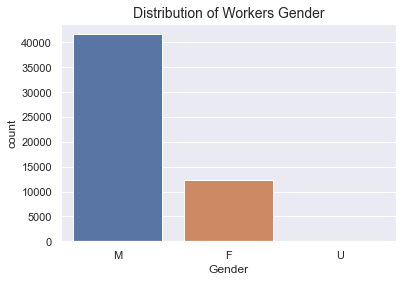

In [8]:
sns.countplot(data=df, x='Gender')
plt.title("Distribution of Workers Gender", size=14);

Most of the claims are from male policyholders.

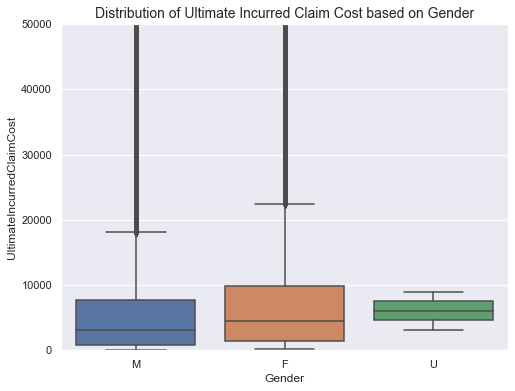

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Gender', y='UltimateIncurredClaimCost')
plt.ylim(0, 50_000)
plt.title('Distribution of Ultimate Incurred Claim Cost based on Gender', size=14);

The average ultimate incurred claim cost are greater for male than female and highly skewed to the right.

In [10]:
# Insert new column that shows the report lag (difference between report date and accident date)
df.insert(3, 'ReportLag (Days)', (pd.to_datetime(df['DateReported'].str.slice(0, 10)) 
                                    - pd.to_datetime(df['DateTimeOfAccident'].str.slice(0, 10))).dt.days)
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,ReportLag (Days),Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredClaimCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,87,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,13,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,20,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,30,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,29,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


In [11]:
df.corr()['UltimateIncurredClaimCost']

ReportLag (Days)             0.027835
Age                          0.102716
DependentChildren            0.033450
DependentsOther              0.027560
WeeklyWages                  0.151695
HoursWorkedPerWeek           0.004543
DaysWorkedPerWeek            0.001901
InitialIncurredClaimCost     0.394991
UltimateIncurredClaimCost    1.000000
Name: UltimateIncurredClaimCost, dtype: float64

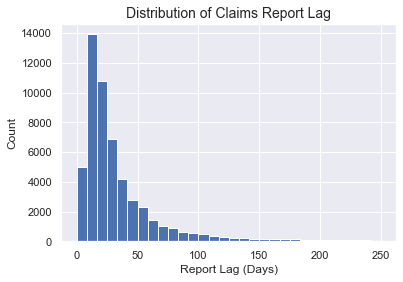

In [12]:
df['ReportLag (Days)'].hist(bins=30, range=(0, 250))
plt.xlabel('Report Lag (Days)')
plt.ylabel('Count')
plt.title("Distribution of Claims Report Lag", size=14);

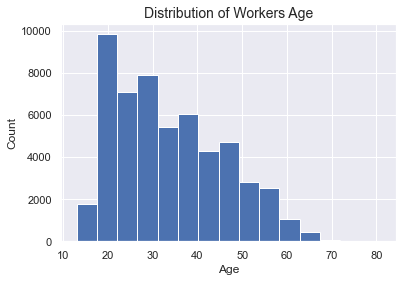

In [13]:
df['Age'].hist(bins=15)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Workers Age', size=14);

The Distribution of age and report lag are also right-skewed.

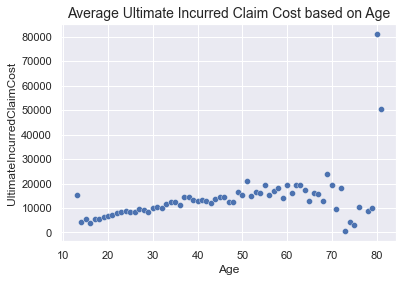

In [14]:
sns.scatterplot(data=df.groupby('Age')['UltimateIncurredClaimCost'].mean().reset_index(),
                x='Age', y='UltimateIncurredClaimCost', linewidth=.3)
plt.title('Average Ultimate Incurred Claim Cost based on Age', size=14);

The ultimate incurred claim cost tends to increase as the insured gets older but eventually decrease. Hence the `age` variable may have quadratic relationship with the ultimate incurred claim cost.

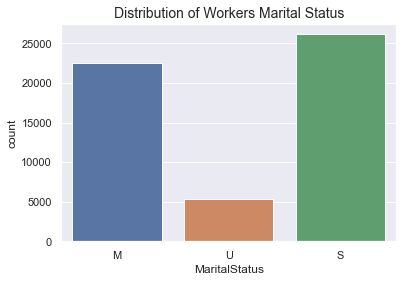

In [15]:
df['MaritalStatus'] = df['MaritalStatus'].fillna('U')
sns.countplot(data=df, x='MaritalStatus')
plt.title('Distribution of Workers Marital Status', size=14);

In [16]:
df.groupby('MaritalStatus')['UltimateIncurredClaimCost'].mean()

MaritalStatus
M    12024.933597
S     9105.578095
U    16009.299588
Name: UltimateIncurredClaimCost, dtype: float64

In [17]:
df['DependentChildren'].value_counts()

0    50639
2     1361
1     1273
3      528
4      150
5       42
6        5
8        1
9        1
Name: DependentChildren, dtype: int64

In [18]:
df['DependentsOther'].value_counts()

0    53506
1      462
2       23
3        8
5        1
Name: DependentsOther, dtype: int64

Most of the workers related to the claims don't have any dependents

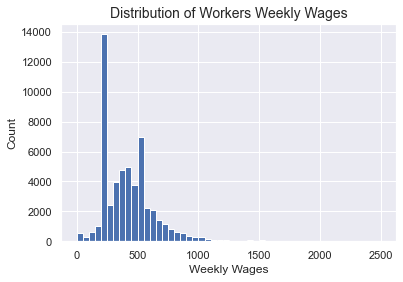

In [19]:
df['WeeklyWages'].hist(bins=50, range=(0, 2500))
plt.xlabel('Weekly Wages')
plt.ylabel('Count')
plt.title('Distribution of Workers Weekly Wages', size=14);

The most common weekly wages are around 250-500 CU. The distribution are also right-skewed.

In [20]:
df.loc[df['WeeklyWages'] < 5, 'WeeklyWages'].value_counts()

1.00    122
4.73      2
3.95      2
4.61      1
3.59      1
1.91      1
Name: WeeklyWages, dtype: int64

Some of the workers related to the claims have weekly wages less than 5 CU and most of them are 1. Hence, we will assume that these are missing values and change it no NaN in the preprocessing steps.

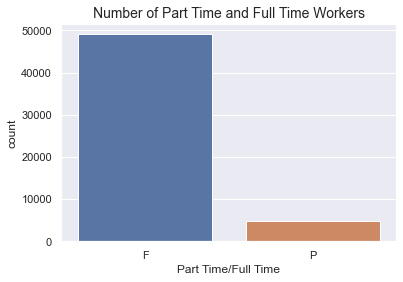

In [21]:
sns.countplot(data=df, x='PartTimeFullTime')
plt.xlabel('Part Time/Full Time')
plt.title('Number of Part Time and Full Time Workers', size=14);

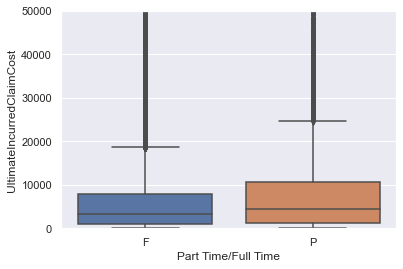

In [22]:
sns.boxplot(data=df, x='PartTimeFullTime', y='UltimateIncurredClaimCost')
plt.xlabel('Part Time/Full Time')
plt.ylim(0, 50_000);

Most of the claims come from full time workers, although the average of ultimate incurred claim cost for this group is lower than the part time

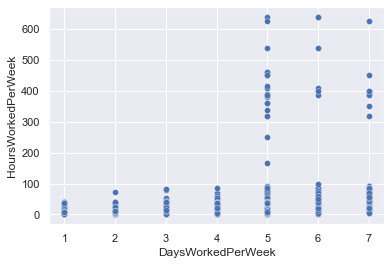

In [23]:
sns.scatterplot(data=df[['HoursWorkedPerWeek', 'DaysWorkedPerWeek']],
                x='DaysWorkedPerWeek', y='HoursWorkedPerWeek', linewidth=.3);

In [24]:
# Assume workers work maximum 18 hours per day
# If the hours worked per week is greater than 18 times days worked per week, the data are incorrect
(df['HoursWorkedPerWeek'] > df['DaysWorkedPerWeek'] * 18).sum()

78

There are only 168 hours per week. However there are some workers that work more than 200 hours a week. Moreover, if we assume a worker works for maximum 18 hours a day, there are several workers where the hours worked per week is greater than 18 times days worked per week. Therefore, we will cap the `HoursWorkedPerWeek` column values to `DaysWorkedPerWeek` times 18.

## Data Preparation

In [25]:
# Split the data into predictor and response variables
X = df_copy.drop('UltimateIncurredClaimCost', axis=1)
y = df_copy['UltimateIncurredClaimCost'].values

In [26]:
def preprocess_data(X):
    '''
    Preprocess data according to analysis from previous section and encode the categorical variables into dummies

    INPUT:
    X - dataframe to be processed

    OUTPUT:
    pandas dataframe containing processed data
    '''
    
    X = X.rename(
        columns={'InitialIncurredCalimsCost': 'InitialIncurredClaimCost'})

    X['ReportLag (Days)'] = (pd.to_datetime(X['DateReported'].str.slice(0, 10))
                             - pd.to_datetime(X['DateTimeOfAccident'].str.slice(0, 10))).dt.days
    
    X['Accident Year'] = X['DateTimeOfAccident'].str.slice(0, 4).apply(int)  # get the accident year

    # Drop columns not needed for prediction
    # We also drop InitialIncurredClaimCost column because we want to know how the ML algorithms will perform
    # without input from actuarial estimation
    X = X.drop(['ClaimNumber', 'DateTimeOfAccident',
                'DateReported', 'InitialIncurredClaimCost'], axis=1)
    
    # Change weekly wages that are less than 5 to NaN
    X.loc[X['WeeklyWages'] < 5, 'WeeklyWages'] = np.nan
    
    # Cap the `HoursWorkedPerWeek` column values to `DaysWorkedPerWeek` times 18.
    X['HoursWorkedPerWeek'] = X.apply(lambda row: row['DaysWorkedPerWeek'] * 18 
                                      if (row['HoursWorkedPerWeek'] > row['DaysWorkedPerWeek'] * 18)
                                      else row['HoursWorkedPerWeek'], axis=1)
    
    # Fill Gender and Marital Status missing values with unknown
    X['Gender'] = X['Gender'].fillna('U')
    X['MaritalStatus'] = X['MaritalStatus'].fillna('U')

    # Change categorical features to dummy variables
    X['Gender_M'] = X['Gender'].apply(lambda x: 1 if x == 'M' else 0)
    X['Gender_F'] = X['Gender'].apply(lambda x: 1 if x == 'F' else 0)
    X['PartTimeFullTime'] = X['PartTimeFullTime'].replace({'F': 1, 'P': 0})
    X['MaritalStatus_M'] = X['MaritalStatus'].apply(
        lambda x: 1 if x == 'M' else 0)
    X['MaritalStatus_S'] = X['MaritalStatus'].apply(
        lambda x: 1 if x == 'S' else 0)
    X = X.drop(['Gender', 'MaritalStatus'], axis=1)
    return X


X = preprocess_data(X)

In [27]:
X.head()

,Age,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,ReportLag (Days),Accident Year,Gender_M,Gender_F,MaritalStatus_M,MaritalStatus_S
0,48,0,0,500.00,1,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,87,2002,1,0,1,0
1,43,0,0,509.34,1,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,13,1999,0,1,1,0
2,30,0,0,709.10,1,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,20,1996,1,0,0,0
3,41,0,0,555.46,1,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,30,2005,1,0,0,1
4,36,0,0,377.10,1,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,29,1990,1,0,1,0


In [28]:
X.dtypes

Age                     int64
DependentChildren       int64
DependentsOther         int64
WeeklyWages           float64
PartTimeFullTime        int64
HoursWorkedPerWeek    float64
DaysWorkedPerWeek       int64
ClaimDescription       object
ReportLag (Days)        int64
Accident Year           int64
Gender_M                int64
Gender_F                int64
MaritalStatus_M         int64
MaritalStatus_S         int64
dtype: object

In [29]:
# split the dataset into train and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

# split the original dataframe to compute mean squared error from actuarial estimation
_, df_val = train_test_split(df, test_size=.2, random_state=42)

In [30]:
# compute mean squared error from actuarial estimation 
np.sqrt(mean_squared_error(df_val['UltimateIncurredClaimCost'],
                           df_val['InitialIncurredClaimCost']))

27869.324453139514

This metric acts as the baseline to score our ML models. The mean squared error of the ML models should not significantly higher than this if it cannot be lower because of limited data.

## Data Modeling And Validation

In [31]:
def tokenize(text):
    '''
    Processes text to list of tokens
    
    INPUT:
    text
    
    OUTPUT:
    list - tokens generated from the text
    '''
    tokens = word_tokenize(text)
    return [WordNetLemmatizer().lemmatize(tok).lower().strip() for tok in tokens
        if tok not in stopwords.words("english")]

In [32]:
# Create ML pipelines to process the data and use Linear Regression as the regressor
lin_reg = Pipeline([('trans_col', # vectorize the claim description column 
                                  # add polynomial features of degree 2 to variable age
                     ColumnTransformer([('vectorizer', CountVectorizer(tokenizer=tokenize,
                                                                       binary=True), 'ClaimDescription'),
                                        ('poly', PolynomialFeatures(2, include_bias=False), ['Age'])],
                                       remainder='passthrough', sparse_threshold=0)),
                    ('scaler', StandardScaler()),  # Standardize the features
                    ('imputer', SimpleImputer()),  # impute missing values using the mean of train data column
                    ('dim_red', PCA(256)),  # reduce feature dimension
                    ('reg', LinearRegression(n_jobs=-1))])
# fit the model to the train data
lin_reg.fit(X_train, y_train)

# calculate mean squared error on validation data
y_val_pred = lin_reg.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_val_pred))

29090.640778951813

The mean squared error is only 5% higher than the actuarial method. Therefore the linear regression model is acceptable.

In [33]:
# Use random forest as the regressor
rf_reg = Pipeline([('trans_col',
                    ColumnTransformer([('vectorizer', CountVectorizer(tokenizer=tokenize,
                                                                      binary=True), 'ClaimDescription'),
                                       ('poly', PolynomialFeatures(2, include_bias=False), ['Age'])],
                                      remainder='passthrough', sparse_threshold=0)),
                   ('imputer', SimpleImputer()),  
                   ('scaler', StandardScaler()),
                   ('dim_red', PCA(256)),
                   ('reg', RandomForestRegressor(n_jobs=-1))])

rf_reg.fit(X_train, y_train)

y_val_pred = rf_reg.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_val_pred))

31204.935560117963

the random forest model has higher MSE than the linear model.

In [34]:
def create_model():
    '''
    Create Neural Network models
    
    INPUT:
    None
    
    OUTPUT:
    keras model
    '''
    model = models.Sequential([layers.Dense(256, activation='relu'),
                               layers.Dropout(.5),
                               layers.Dense(128, activation='relu'),
                               layers.Dropout(.5),
                               layers.Dense(64, activation='relu'),
                               layers.Dropout(.5),
                               layers.Dense(16, activation='relu'),
                               layers.Dropout(.5),
                               layers.Dense(1, activation='relu')])
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [35]:
# Use neural network as the regressor
nn_reg = Pipeline([('trans_col',
                    ColumnTransformer([('vectorizer', CountVectorizer(tokenizer=tokenize,
                                                                      binary=True), 'ClaimDescription'),
                                       ('poly', PolynomialFeatures(2, include_bias=False), ['Age'])],
                                      remainder='passthrough', sparse_threshold=0)),
                   ('imputer', SimpleImputer()),
                   ('scaler', StandardScaler()),
                   ('reg', KerasRegressor(create_model, epochs=50, batch_size=256, verbose=0))])

nn_reg.fit(X_train, y_train)

y_val_pred = nn_reg.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_val_pred))

31303.116443064053

Because the linear model produces the lowest validation error, we will use it to make prediction on test data. But first we need to determine the best hyperparameter for the linear model using GridSearch

In [36]:
# Use GridSearch to find the best hyperparameter
param_grid = {'dim_red__n_components': [128, 256, 512],
              'imputer__fill_value' : ['mean', 'median']}

final_model = GridSearchCV(lin_reg, param_grid)

final_model.fit(X_train, y_train)

y_val_pred = final_model.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_val_pred))

29088.602138296203

## Make Predictions on Test Data

In [37]:
df_test = pd.read_csv('data/test.csv')

In [38]:
df_test.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost
0,WC8145235,2002-04-02T10:00:00Z,2002-05-07T00:00:00Z,26,M,S,1,0,600.18,F,40.0,5,CAUGHT RIGHT HAND WITH HAMMER BURN TO RIGHT HAND,5300
1,WC2005111,1988-04-06T16:00:00Z,1988-04-15T00:00:00Z,31,M,M,0,0,311.54,F,35.0,5,SPRAINED RIGHT ANKLE FRACTURE RIGHT ELBOW,2000
2,WC6899143,1999-03-08T09:00:00Z,1999-04-04T00:00:00Z,57,M,M,0,0,1000.00,F,38.0,5,STRUCK HAMMER CRUSH INJURY FINGERS HAND,20000
3,WC5502023,1996-07-26T09:00:00Z,1996-09-04T00:00:00Z,33,M,M,0,0,200.00,F,38.0,5,STRUCK AGAINST AIR HOSE STRUCK GLASS LACERATIO...,350
4,WC4785156,1994-04-13T14:00:00Z,1994-07-07T00:00:00Z,32,F,M,0,0,359.60,F,40.0,5,FOREIGN BODY IN RIGHT FOOT BRUISED RIGHT BIG TOE,3000


In [39]:
X_test = preprocess_data(df_test)

In [40]:
# fit the model to the full train and validation data before making prediction
best_model = final_model.best_estimator_
best_model.fit(X, y)
y_pred = final_model.predict(X_test)

In [41]:
# Export the prediction to csv files
df_test['UltimateIncurredClaimCost'] = y_pred
df_test[['ClaimNumber', 'UltimateIncurredClaimCost']].to_csv('data/submission.csv', index=False)